In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

import torch 
from torch import nn
from sklearn.datasets import make_moons

In [2]:
def get_activation(name: str, **kwargs):
    activations = {
        'relu': nn.ReLU,
        'tanh': nn.Tanh,
        'sigmoid': nn.Sigmoid,
        'silu': nn.SiLU,
        'softplus': nn.Softplus,
        'leakyrelu': nn.LeakyReLU
    }
    if name in activations.keys():
        return activations[name.lower()](**kwargs)
    else:
        raise KeyError('No such activation')

In [3]:
class MLP(nn.Module):
    def __init__(self, neurons: List[int], activations: List[str], dropout_rate=0):
        super().__init__()
        self.n_layers = len(neurons) - 1
        # self.output_activation = nn.Sigmoid() if neurons[-1] == 1 else nn.Softmax(dim=1)
        # self.layers = nn.ModuleList([nn.Linear(neurons[i], neurons[i+1]) for i in range(self.n_layers)])
        # self.activations = [get_activation(a) for a in activations]
        self.blocks = nn.ModuleList()
        for i in range(self.n_layers-1):
            self.blocks.append(
                nn.Sequential(
                    nn.Dropout(dropout_rate),
                    nn.Linear(neurons[i], neurons[i+1]),
                    nn.BatchNorm1d(neurons[i+1]),
                    get_activation(activations[i])
                ))
        self.blocks.append(
            nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(neurons[-2], neurons[-1]),
                nn.Sigmoid() if neurons[-1] == 1 else nn.Softmax(dim=1)
            ))
        
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

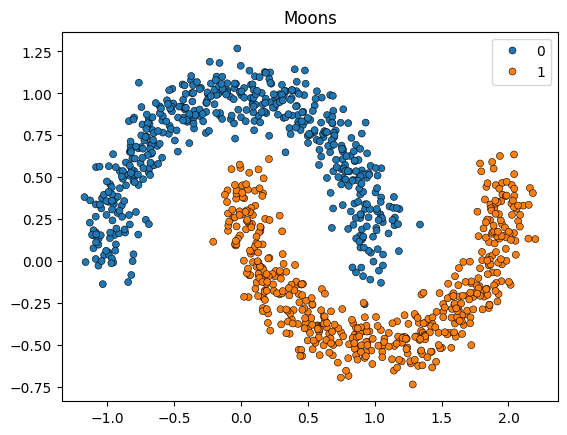

In [4]:
points, labels = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=0)
sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=labels, marker="o", s=25, edgecolor="k", legend=True
).set_title("Moons")
plt.show()

In [5]:
net = MLP([2, 20, 20, 20, 20, 1], ['relu', 'relu', 'relu', 'relu'])
X = torch.tensor(points).float()
y = torch.tensor(labels).reshape(-1, 1).float()

In [6]:
epochs = 500
lr = 1e-3

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = nn.BCELoss()

train_losses = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

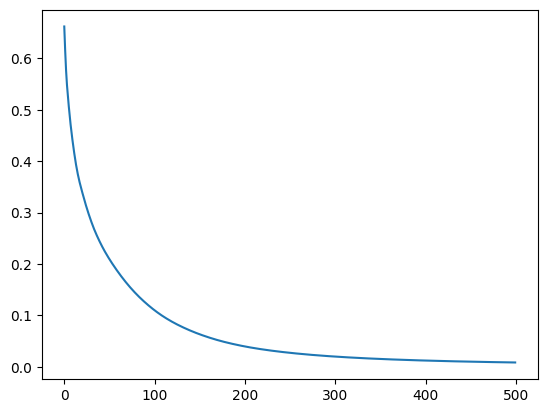

In [7]:
plt.plot(train_losses)

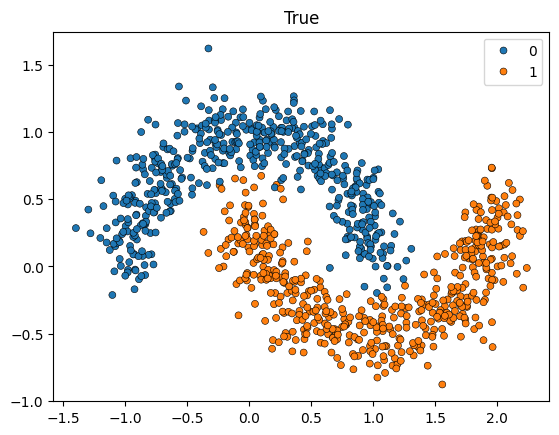

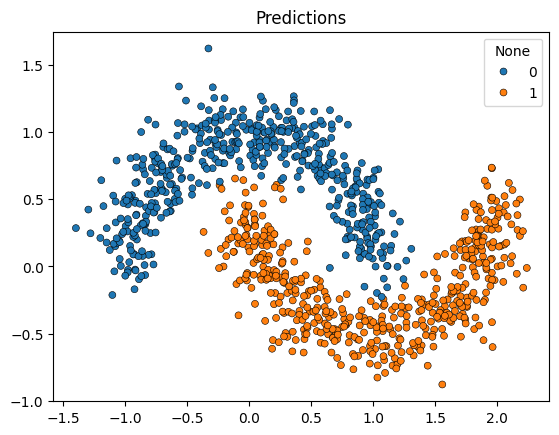

In [8]:
points, labels = make_moons(n_samples=1000, shuffle=True, noise=0.15, random_state=4)
sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=labels, marker="o", s=25, edgecolor="k", legend=True
).set_title("True")
plt.show()

sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=torch.where(net(torch.tensor(points).float()).detach().reshape(-1) > .5, 1, 0), marker="o", s=25, edgecolor="k", legend=True
).set_title("Predictions")
plt.show()